In [ ]:
import GPI_init_fit as gpi
import numpy as np
import matplotlib.pyplot as plt
import optimization.interpolated_univariate_spline as spline_func
from astropy.stats import bayesian_info_criterion as bic
from astropy.stats import akaike_info_criterion as aic

import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"
from astropy.io import fits
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.15'
jax.config.update("jax_enable_x64", True)
import pandas as pd
from optimization.optimize_framework import Optimizer, OptimizeUtils
from disk_model.objective_functions import objective_model, objective_ll, objective_fit, Parameter_Index
from disk_model.SLD_ojax import ScatteredLightDisk
from disk_model.SLD_utils import *

/home/blewis/anaconda3/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
CuPy succesfully imported. Using GPU where applicable. Set use_gpu=False to override this functionality.


In [ ]:
name = 'hd145560_H_pol'
disk_name = "HD145560"
fits_image_filepath = "/home/blewis/GPI_data/" + str(name) + ".fits"
hdul = fits.open(fits_image_filepath)

target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:])
err_map = OptimizeUtils.process_image(OptimizeUtils.create_empirical_err_map(hdul['SCI'].data[2,:,:]))
misc_params = Parameter_Index.misc_params

num_knots = 6

spf_params = InterpolatedUnivariateSpline_SPF.params
psf_params = EMP_PSF.params
disk_params = Parameter_Index.disk_params

image_data = pd.read_csv('image_info_filt.csv')
image_data.set_index("Name", inplace=True)
image_data.columns = ["Radius", "Inclination", "Position Angle", "Distance", "a_in", "a_out", "eccentricity", "ksi0", "gamma", "beta", "omega", "x_center", "y_center", "knots"]
row = image_data.loc[name]

disk_params['sma'] = row["Radius"]
disk_params['inclination'] = row["Inclination"]
disk_params['position_angle'] = row["Position Angle"]
misc_params['distance'] = row["Distance"]
spf_params['num_knots'] = num_knots
spf_params['knot_values'] = jnp.full(spf_params['num_knots'],0.5)
disk_params['alpha_in'] = row['a_in']
disk_params['alpha_out'] = row['a_out']
disk_params['e'] = row['eccentricity']
disk_params['ksi0'] = row['ksi0']
disk_params['gamma'] = row['gamma']
disk_params['beta'] = row['beta']
disk_params['omega'] = row['omega']
disk_params['x_center'] = 70
disk_params['y_center'] = 70

In [ ]:
opt = Optimizer(disk_params, spf_params, psf_params, misc_params, 
                ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)
opt.name = disk_name
fit_keys = ['alpha_in', 'alpha_out', 'sma', 'e', 'ksi0','gamma','beta','omega','inclination', 'position_angle', 'x_center', 'y_center', 'flux_scaling','knot_values']
array_params = ['knot_values']
logscaled_params = []
opt.inc_bound_knots()
opt.scale_initial_knots(target_image)

##initial minimization

soln = opt.scipy_optimize(fit_keys, logscaled_params, array_params, target_image, err_map, disp_soln=True,iters = 1000)
opt.scale_spline_to_fixed_point(0, 1)
opt.save_human_readable('../GPI_results')
opt.save_machine_readable('../GPI_results')

##bounded minimization

bounds = ([0.01, -45,   0, 0,0.01, 0.01,-15,-20,   0, -20, 60,  60,    0, np.zeros(num_knots)],
          [45, -0.01, 150, 1, 200,  200, 15,380, 180, 380, 90,  90,  5e6, 1e4*np.ones(num_knots)])

soln = opt.scipy_bounded_optimize(fit_keys, bounds, logscaled_params, array_params, target_image, err_map, disp_soln=True,iters = 1000)
opt.scale_spline_to_fixed_point(0, 1)
opt.save_human_readable('../GPI_results')
opt.save_machine_readable('../GPI_results')

optimal_image = opt.model()
optimal_ll = opt.log_likelihood(target_image,err_map)

         Current function value: 42786.771137
         Iterations: 126
         Function evaluations: 4129
         Gradient evaluations: 206
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 42786.771136943076
        x: [ 7.153e+00 -1.407e+00 ...  2.100e+00  3.466e-01]
      nit: 126
      jac: [ 8.789e-03 -2.148e-02 ... -1.367e-02  1.465e-03]
 hess_inv: [[ 6.560e-01  4.939e-01 ...  1.396e-02 -2.933e-02]
            [ 4.939e-01  4.909e-01 ...  1.151e-02 -3.070e-02]
            ...
            [ 1.396e-02  1.151e-02 ...  2.115e-02  5.657e-03]
            [-2.933e-02 -3.070e-02 ...  5.657e-03  2.818e-02]]
     nfev: 4129
     njev: 206
Saved human readable file to ../GPI_results/HD145560_scipyminimize_hrparams.txt
NOTE: SPF SAVING NOT YET IMPLEMENTED
NOTE: MISC PARM SAVING NOT YET IMPLEMENTED
Saved machine readable files to json in ../GPI_results
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19      1     21      2     0     1   2.415D+02   4.279D+04
  F =   42786.771136943076     

ABNORMAL_TERMINATION_IN_LNSRCH                              
  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 42786.77151906855
        x: [ 7.153e+00 -1.407e+00 ...  4.891e-01  8.074e-02]
      nit: 0
      jac: [ 8.731e-03 -2.183e-02 ... -5.821e-02  6.548e-03]
     nfev: 420
     njev: 21
 hess_inv: <19x19 LbfgsInvHessProduct with dtype=float64>
Saved human readable file to ../GPI_results/HD145560_scipyboundminimize_hrparams.txt
NOTE: SPF SAVIN

In [8]:
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': 7.153399753770394, 'alpha_out': -1.4066407234928904, 'sma': 78.13262695630073, 'e': 0.019320392682294973, 'ksi0': 2.6685151296106913, 'gamma': 4.4881328117220285, 'beta': -0.8489088845470345, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': 44.38643025223475, 'position_angle': 221.4871044517139, 'x_center': 73.0033122726021, 'y_center': 72.6255670037132, 'halfNbSlices': 25, 'omega': 32.60329372881276}
SPF Params: {'low_bound': Array(-0.69340183, dtype=float64), 'up_bound': Array(0.69340183, dtype=float64), 'num_knots': 6, 'knot_values': Array([1.95534421, 1.52891049, 1.27784849, 0.72444227, 0.48905773,
       0.08073561], dtype=float64)}
PSF Params: {'scale_factor': 1, 'offset': 1}
Misc Params: {'distance': 120.44, 'pxInArcsec': 0.01414, 'nx': 140, 'ny': 140, 'halfNbSlices': 25, 'flux_scaling': Array(1582.07125896, dtype=float64)}


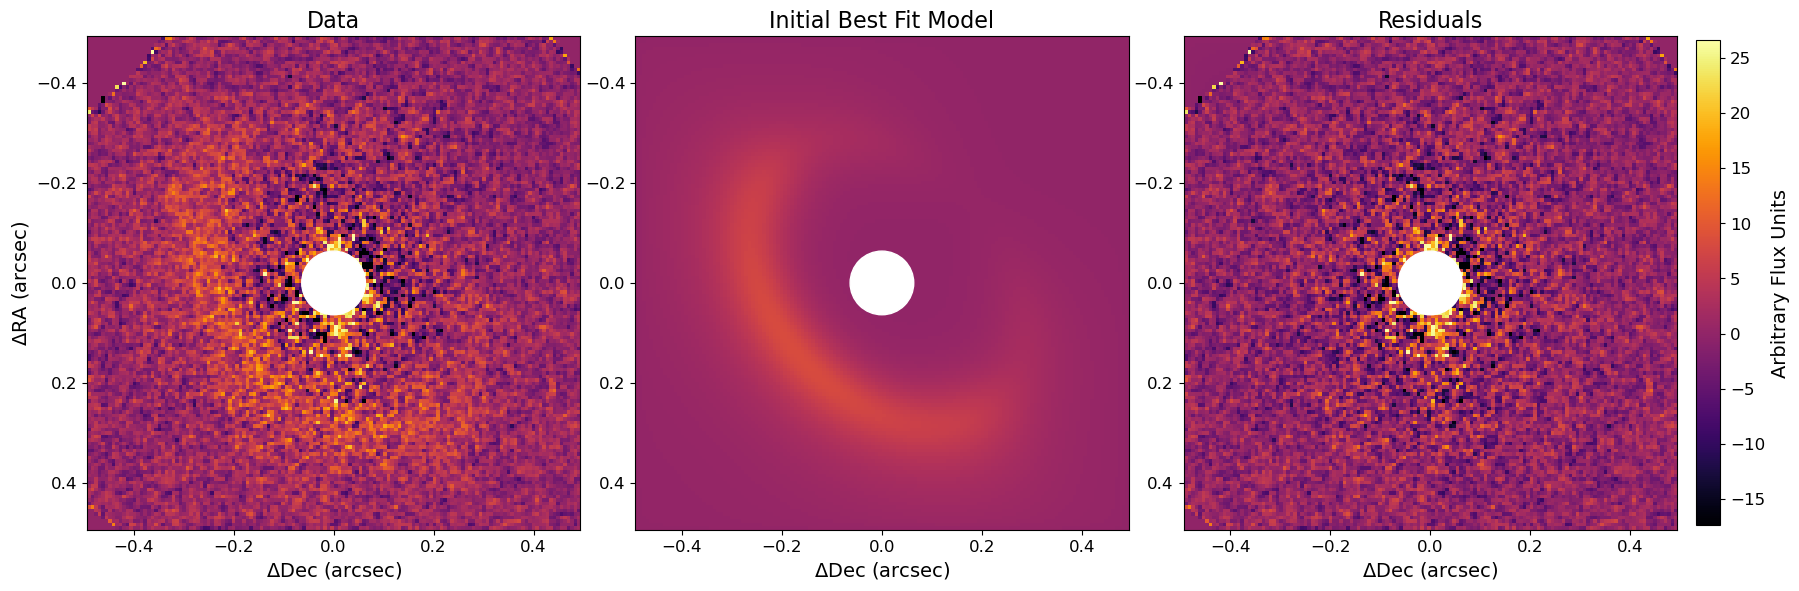

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20,10))
mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 5)
vmax = np.nanpercentile(target_image[mask], 95)

xmax=70
extent = [-(xmax*14.1)/2000, (xmax*14.1)/2000, (xmax*14.1)/2000, -(xmax*14.1)/2000]

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

mask_circle1 = plt.Circle((0,0), (9/2)*float(misc_params['pxInArcsec']), color='white')
mask_circle2 = plt.Circle((0,0), (9/2)*float(misc_params['pxInArcsec']), color='white')
mask_circle3 = plt.Circle((0,0), (9/2)*float(misc_params['pxInArcsec']), color='white')

im = axes[0].imshow(target_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[0].set_title("Data",fontsize=16)
axes[0].set_ylabel('$\Delta$RA (arcsec)',fontsize=14)
axes[0].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
axes[0].add_artist(mask_circle1)
#plt.colorbar(im, ax=axes[0], shrink=0.5)
im.set_clim(vmin, vmax)

im = axes[1].imshow(optimal_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[1].set_title("Initial Best Fit Model",fontsize=16)
#plt.colorbar(im, ax=axes[1], shrink=0.5)
im.set_clim(vmin, vmax)
axes[1].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
axes[1].add_artist(mask_circle2)

im = axes[2].imshow(target_image-optimal_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=10)
axes[2].set_title("Residuals",fontsize=16)
im.set_clim(vmin, vmax)
axes[2].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
plt.tight_layout()
cb = plt.colorbar(im, ax=axes, shrink=0.5,pad=0.01)
cb.set_label('Arbitrary Flux Units',fontsize=14)#,rotation=270)
cb.ax.tick_params(labelsize=12)
axes[2].add_artist(mask_circle3)
plt.savefig('../GPI_results/{}_scipyboundminimize_fit.png'.format(disk_name))

133.9 46.1
[1.95534421 1.52891049 1.27784849 0.72444227 0.48905773 0.08073561]


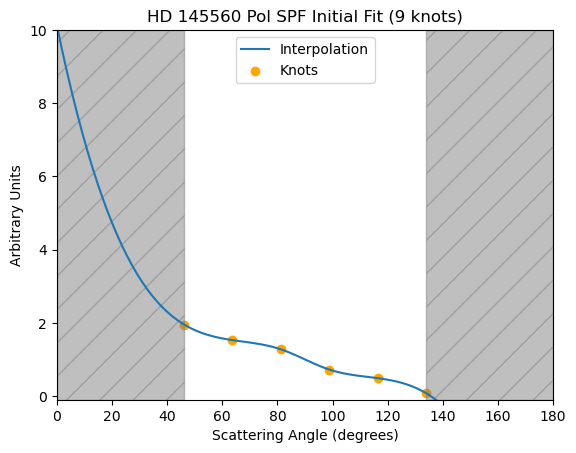

In [ ]:
spf1 = opt.spf_params

hi = np.rad2deg(np.arccos(spf1['low_bound']))
lo = np.rad2deg(np.arccos(spf1['up_bound']))
print(hi,lo)

print(spf1['knot_values'])
spf = spline_func.InterpolatedUnivariateSpline(np.linspace(lo,hi,num_knots),spf1['knot_values'])

func = spf.__call__(np.linspace(0,180,100))

import matplotlib.pyplot as plt
plt.plot(np.linspace(0,180,100),func,label='Interpolation')
plt.scatter(np.linspace(lo,hi,num_knots),spf1['knot_values'],color='orange',label='Knots')
ax = plt.gca()
ax.axvspan(hi,180,alpha=0.5,color='grey',hatch='/')
ax.axvspan(0,lo,alpha=0.5,color='grey',hatch='/')

###CHANGE NAMES
plt.title('{} Pol SPF Initial Fit ({} knots)'.format(disk_name, num_knots))
plt.xlabel('Scattering Angle (degrees)')
plt.ylabel('Arbitrary Units')
plt.legend()
plt.xlim(0,180)
plt.ylim(-0.1,10)
plt.savefig('../GPI_results/best_fits/{}_scipyboundminimize_pol_spf.png'.format(disk_name),bbox_inches='tight')

In [ ]:
##important! number of steps, continue from

mc_model = opt.mcmc(fit_keys, logscaled_params, array_params,target_image, err_map, bounds, nwalkers=100, niter=4600, burns=20, continue_from=True)

In [ ]:
mc_soln = np.median(mc_model.sampler.flatchain, axis=0)
img = opt.model()
opt.print_params()
samples = mc_model.sampler.get_chain()

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20,10))
mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

xmax=70
extent = [-(xmax*14.1)/2000, (xmax*14.1)/2000, (xmax*14.1)/2000, -(xmax*14.1)/2000]

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

mask_circle1 = plt.Circle((0,0), (9/2)*float(misc_params['pxInArcsec']), color='white')
mask_circle2 = plt.Circle((0,0), (9/2)*float(misc_params['pxInArcsec']), color='white')
mask_circle3 = plt.Circle((0,0), (9/2)*float(misc_params['pxInArcsec']), color='white')

im = axes[0].imshow(target_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[0].set_title("Data",fontsize=16)
axes[0].set_ylabel('$\Delta$RA (arcsec)',fontsize=14)
axes[0].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
#plt.colorbar(im, ax=axes[0], shrink=0.5)
axes[0].add_artist(mask_circle1)
im.set_clim(vmin, vmax)

im = axes[1].imshow(img, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[1].set_title("MCMC Best Fit Model",fontsize=16)
#plt.colorbar(im, ax=axes[1], shrink=0.5)
im.set_clim(vmin, vmax)
axes[1].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
axes[1].add_artist(mask_circle2)

im = axes[2].imshow(target_image-img, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[2].set_title("Residuals",fontsize=16)
im.set_clim(vmin, vmax)
axes[2].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
axes[2].add_artist(mask_circle3)
plt.tight_layout()
cb = plt.colorbar(im, ax=axes, shrink=0.5,pad=0.01)
cb.set_label('Arbitrary Flux Units',fontsize=14)#,rotation=270)
cb.ax.tick_params(labelsize=12)
plt.savefig('../GPI_results/{}_MCMC_fit.png'.format(disk_name))

In [ ]:
spf1 = opt.spf_params

hi = np.rad2deg(np.arccos(spf1['low_bound']))
lo = np.rad2deg(np.arccos(spf1['up_bound']))
print(hi,lo)

print(spf1['knot_values'])
spf = spline_func.InterpolatedUnivariateSpline(np.linspace(lo,hi,num_knots),spf1['knot_values'])

func = spf.__call__(np.linspace(0,180,100))

import matplotlib.pyplot as plt
plt.plot(np.linspace(0,180,100),func,label='Interpolation')
plt.scatter(np.linspace(lo,hi,num_knots),spf1['knot_values'],color='orange',label='Knots')
ax = plt.gca()
ax.axvspan(hi,180,alpha=0.5,color='grey',hatch='/')
ax.axvspan(0,lo,alpha=0.5,color='grey',hatch='/')

###CHANGE NAMES
plt.title('{} Pol SPF Initial Fit ({} knots)'.format(disk_name, num_knots))
plt.xlabel('Scattering Angle (degrees)')
plt.ylabel('Arbitrary Units')
plt.legend()
plt.xlim(0,180)
plt.ylim(-0.1,10)
plt.savefig('../GPI_results/best_fits/{}_MCMC_pol_spf.png'.format(disk_name),bbox_inches='tight')

In [ ]:
labels = 'a$_{in}$', 'a$_{out}$', 'A', 'e', 'xi$_0$', 'gamma', 'beta', 'omega', 'i', 'PA', 'x$_{c}$', 'y$_{c}$', 'flux']
for i in range(0, opt.spf_params['num_knots']):
    labels.append('k'+str(i+1))
mc_model.plot_chains(labels)
plt.savefig('../GPI_results/{}_MCMC_chains.png'.format(disk_name),bbox_inches='tight')

In [ ]:
mc_model.show_corner_plot(labels, truths=mc_soln)
plt.savefig('../GPI_results/{}_MCMC_corner.png'.format(disk_name),bbox_inches='tight')

In [ ]:
mc_model.sampler.get_autocorr_time()